In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
from implementations import *
import matplotlib.pyplot as plt

In [3]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

In [4]:
def extend_and_standardize(input_data, mean=None, std=None):
    if mean is not None and std is not None:
        mean_x = mean
        std_x = std
        tx = (input_data - mean) / std
        num_samples = input_data.shape[0]
        tx = np.c_[np.ones(num_samples), tx]
    else: 
        x, mean_x, std_x = standardize(input_data)
        tx = build_model_data(x)
    return tx, mean_x, std_x

In [5]:
def reconstruct_labels():
    raise NotImplemented

In [6]:
def model_output(tx, ws, pri_jet_num_idx, clean_features, parameters):
    cond_null = tx[:, pri_jet_num_idx] == 0
    cond_one = tx[:, pri_jet_num_idx] == 1
    cond_plural = tx[:, pri_jet_num_idx] >= 2
    conditions = (cond_null, cond_one, cond_plural)

    N = tx.shape[0]
    model_output = np.zeros(N)
    for pri_jet_num, cond in enumerate(conditions):
        select_features = clean_features[pri_jet_num]
        reduced_dset = tx[cond][:,select_features]
        mean, std = parameters[pri_jet_num]
        extended_dset,_,_ = extend_and_standardize(reduced_dset,mean,std)
        weight = ws[pri_jet_num]
        sub_output = extended_dset.dot(weight)
        model_output[cond] = sub_output
        
    return model_output

In [84]:
def compute_predictions(model_output):
    predictions = model_output
    predictions[predictions > 0.5] = 1 
    predictions[predictions <= 0.5] = 0 
    return predictions

In [85]:
def logistic_predictions(model_output):
    predictions = np.sign(model_output)
    predictions[predictions == -1] = 0
    return predictions

In [9]:
def compute_accuracy(y, predictions):
    N = y.size
    accuracy = 1 - (np.count_nonzero(predictions-y)/N)
    print("Accuracy: {}".format(accuracy))

In [22]:
def save_results(weights, clean_features, parameters):
    np.save('all/weights.npy', weights)
    np.save('all/clean_features.npy', clean_features)
    np.save('all/parameters.npy', parameters)

# Part 1: Without feature engineering

### Import Dataset

In [42]:
train_data = 'all/train.csv'
labels, input_data, ids, features = load_csv_data(train_data)

In [43]:
features

array(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot',
       'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta',
       'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi',
       'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num',
       'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt'], dtype='<U27')

In [44]:
i, = np.where(features == 'PRI_jet_num')
categorial_index = np.squeeze(i)
print(categorial_index)

22


In [45]:
tx = extend_and_standardize(input_data)

In [46]:
training_ratio = 0.8

In [47]:
x_tr, x_te, y_tr, y_te = split_data(input_data, labels, training_ratio)

## Gradient descent

In [86]:
initial_w = np.zeros(x_tr.shape[1])
max_iters = 100
gamma = 0.1

In [87]:
losses_GD, ws_GD = least_squares_GD(y_tr, x_tr, initial_w, max_iters, gamma)

Gradient Descent(0/99): loss=0.1710925, w0=-2.9427268665000046, w1=-1.0965389080000032
Gradient Descent(1/99): loss=9044196252.375938, w0=1067369.715524102, w1=-604250.9584981919
Gradient Descent(2/99): loss=2.96613578261203e+21, w0=676556181059.0527, w1=-343691735948.4086
Gradient Descent(3/99): loss=9.74751522294366e+32, w0=3.8974846366841414e+17, w1=-1.969887387915228e+17
Gradient Descent(4/99): loss=3.2033231238617575e+44, w0=2.2349952291066886e+23, w1=-1.1292573538441004e+23
Gradient Descent(5/99): loss=1.05270722272537e+56, w0=1.281269972346089e+29, w1=-6.47360668911357e+28
Gradient Descent(6/99): loss=3.459508936306597e+67, w0=7.345053266512663e+34, w1=-3.711075037454182e+34
Gradient Descent(7/99): loss=1.1368974983795755e+79, w0=4.210643285763422e+40, w1=-2.1274196330067505e+40
Gradient Descent(8/99): loss=3.736183214493115e+90, w0=2.413803341208911e+46, w1=-1.219569598973335e+46
Gradient Descent(9/99): loss=1.227820892574402e+102, w0=1.3837426010619725e+52, w1=-6.9913334617531

/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:6: RuntimeWarning: overflow encountered in square
  return 1/2*np.mean(e**2)
/home/julien/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Gradient Descent(47/99): loss=inf, w0=9.08836037519975e+270, w1=-4.591876982566845e+270
Gradient Descent(48/99): loss=inf, w0=5.210014914860252e+276, w1=-2.6323502346649437e+276
Gradient Descent(49/99): loss=inf, w0=2.986705444376741e+282, w1=-1.5090273071878761e+282
Gradient Descent(50/99): loss=inf, w0=1.7121658108936018e+288, w1=-8.650685550315859e+287
Gradient Descent(51/99): loss=inf, w0=9.815202130201088e+293, w1=-4.95911241194818e+293
Gradient Descent(52/99): loss=inf, w0=5.626685934490384e+299, w1=-2.8428724834924974e+299
Gradient Descent(53/99): loss=inf, w0=inf, w1=-inf
Gradient Descent(54/99): loss=nan, w0=nan, w1=nan
Gradient Descent(55/99): loss=nan, w0=nan, w1=nan
Gradient Descent(56/99): loss=nan, w0=nan, w1=nan
Gradient Descent(57/99): loss=nan, w0=nan, w1=nan
Gradient Descent(58/99): loss=nan, w0=nan, w1=nan
Gradient Descent(59/99): loss=nan, w0=nan, w1=nan
Gradient Descent(60/99): loss=nan, w0=nan, w1=nan
Gradient Descent(61/99): loss=nan, w0=nan, w1=nan
Gradient Desc

In [63]:
w_GD = ws_GD[-1]

In [64]:
ws_GD

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 2.94272687e-02,  1.09653891e-02,  2.75102620e-02,  2.56041405e-02,
        -2.11858017e-01, -1.45857418e-01, -2.12510540e-01,  8.16895690e-04,
         6.30458877e-03,  6.25701617e-02,  4.13644105e-04,  1.11273860e-04,
        -2.12175279e-01,  1.57377058e-02, -4.59088000e-06, -6.39518500e-06,
         1.56228530e-02, -6.00935500e-06,  1.88166500e-05,  1.45894218e-02,
         1.94715000e-06,  7.98476189e-02,  3.96995000e-04, -7.93485458e-02,
        -1.01669647e-01, -1.01670661e-01, -2.04880286e-01, -2.12253652e-01,
        -2.12255425e-01,  3.12096044e-02]),
 array([ 1.06796415e+02, -6.04029458e+01, -9.23697636e+01, -3.84355884e+01,
         1.12706000e+03,  1.13516483e+03,  1.12697427e+03, -2.85423127e+00,
        -1.67887619e+01, -1.18068634e+02, -1.58943812e+00,  5.15068626e-01,
         1.12702983e+03, -4.02580278e+01,  1.82093523e-02,

In [53]:
predictions_GD = compute_predictions(x_te,w_GD)
compute_accuracy(y_te,predictions_GD)

/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


## Stochastic gradient descent

## Least squares

In [57]:
w_LS = least_squares(y_tr,x_tr)

In [60]:
w_LS

array([ 2.93423695e-05, -3.48912943e-03, -3.26343760e-03, -1.51679834e-04,
        1.21211206e-02,  2.12027995e-04, -9.48648403e-03,  1.85929094e-01,
       -1.27078510e-04, -2.83775188e+00, -1.02706124e-01,  4.86724095e-02,
        6.75712296e-03,  2.84230389e+00,  1.55100772e-04, -5.89131487e-04,
        2.84419968e+00,  4.10388756e-05,  3.85893837e-04,  1.79363132e-03,
       -2.06294585e-04, -2.17852008e-04,  2.12432765e-04,  9.49320717e-04,
       -5.80701064e-04, -3.12251922e-04,  1.39182472e-03, -4.00767000e-03,
       -7.01506316e-03,  2.83630071e+00])

In [58]:
predictions = compute_predictions(x_te,w_LS)

In [59]:
compute_accuracy(y_te,predictions)

Accuracy: 0.7453000000000001


## Ridge regression

### Use cross-validation to find good hyperparameter

In [92]:
seed = 1
k_fold = 4
k_indices = build_k_indices(y_tr, k_fold, seed)
lambda_ = 0.001

In [93]:
lambdas, tr_losses, te_losses = find_optimal_lambda(y_tr,x_tr)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29


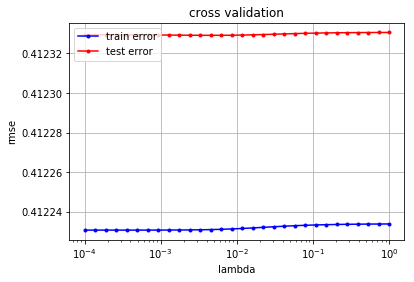

In [96]:
tr_losses = (2*np.array(tr_losses))**(0.5)
te_losses = (2*np.array(te_losses))**(0.5)
cross_validation_visualization(lambdas, tr_losses, te_losses)

In [70]:
optimal_lambda = find_optimal_lambda(y_tr,x_tr)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29


In [72]:
w_rr = ridge_regression(y_tr,x_tr,optimal_lambda)

In [88]:
optimal_lambda

0.004520353656360241

In [73]:
predictions = compute_predictions(x_te,w_rr)

In [75]:
compute_accuracy(y_te,predictions)

Accuracy: 0.7453000000000001


## Logistic regression

In [76]:
initial_w = np.zeros(x_tr.shape[1])
max_iters = 1000
gamma = 0.01

In [77]:
loss, w_logistic = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)

/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: divide by zero encountered in log
  # start the logistic regression
/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: invalid value encountered in multiply
  # start the logistic regression


Current iteration=0, loss=nan
Current iteration=100, loss=nan
Current iteration=200, loss=nan
Current iteration=300, loss=nan
Current iteration=400, loss=nan
Current iteration=500, loss=nan
Current iteration=600, loss=nan
Current iteration=700, loss=nan
Current iteration=800, loss=nan
Current iteration=900, loss=nan


In [80]:
predictions = logistic_predictions(x_te,w_logistic)
compute_accuracy(y_te,predictions)

Accuracy: 0.6876599999999999


## Regularized logistic regression

In [82]:
loss, w_reg_logistic = reg_logistic_regression(y_tr, x_tr, optimal_lambda, initial_w, max_iters, gamma)

/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: divide by zero encountered in log
  loss = (-y * np.log(pred) - (1 - y) * np.log(1 - pred)).mean()
/home/julien/Documents/Epfl/Courses/ML_course/projects/project1/scripts/implementations.py:194: RuntimeWarning: invalid value encountered in multiply
  loss = (-y * np.log(pred) - (1 - y) * np.log(1 - pred)).mean()


Current iteration=0, loss=nan
Current iteration=100, loss=nan
Current iteration=200, loss=nan
Current iteration=300, loss=nan
Current iteration=400, loss=nan
Current iteration=500, loss=nan
Current iteration=600, loss=nan
Current iteration=700, loss=nan
Current iteration=800, loss=nan
Current iteration=900, loss=nan


In [83]:
predictions = logistic_predictions(x_te,w_reg_logistic)
compute_accuracy(y_te,predictions)

Accuracy: 0.6372800000000001


# Part 2: EDA and feature engineering

### Import Dataset

In [143]:
train_data = 'all/train.csv'
labels, input_data, ids, features = load_csv_data(train_data)

In [144]:
training_ratio = 0.8

In [98]:
x_tr, x_te, y_tr, y_te = split_data(input_data, labels, training_ratio)

In [150]:
x_tr[:2]

array([[ 1.00368e+02,  3.58310e+01,  7.71850e+01,  4.12500e+00,
        -9.99000e+02, -9.99000e+02, -9.99000e+02,  3.02200e+00,
         4.12500e+00,  6.41480e+01,  9.88000e-01, -1.41200e+00,
        -9.99000e+02,  3.22700e+01,  1.98700e+00,  1.14000e+00,
         3.18780e+01,  6.82000e-01, -1.58500e+00,  1.37440e+01,
         2.64400e+00,  1.21919e+02,  0.00000e+00, -9.99000e+02,
        -9.99000e+02, -9.99000e+02, -9.99000e+02, -9.99000e+02,
        -9.99000e+02,  0.00000e+00],
       [ 7.66620e+01,  4.15970e+01,  5.76100e+01,  2.09940e+01,
        -9.99000e+02, -9.99000e+02, -9.99000e+02,  2.62700e+00,
         2.09940e+01,  5.95500e+01,  8.16000e-01, -1.40500e+00,
        -9.99000e+02,  3.27900e+01,  4.08000e-01,  1.96800e+00,
         2.67600e+01,  1.86000e-01, -6.50000e-01,  3.74580e+01,
        -2.08300e+00,  1.34038e+02,  0.00000e+00, -9.99000e+02,
        -9.99000e+02, -9.99000e+02, -9.99000e+02, -9.99000e+02,
        -9.99000e+02,  0.00000e+00]])

In [151]:
X, y = x_tr, y_tr  # input_data, labels

i, = np.where(features == 'PRI_jet_num')
pri_jet_num_idx = np.squeeze(i)
cond_null = X[:, pri_jet_num_idx] == 0
cond_one = X[:, pri_jet_num_idx] == 1
cond_plural = X[:, pri_jet_num_idx] >= 2
conditions = (cond_null, cond_one, cond_plural)

dsets = [X[cond] for cond in conditions]
ybs = [y[cond] for cond in conditions]

In [142]:
test = np.array([[1,2,3],[3,1,2],[2,3,1]])
print(test)
col = test[0]
print(col)
col = np.array([7,7,7])
print(col)
print(test)

[[1 2 3]
 [3 1 2]
 [2 3 1]]
[1 2 3]
[7 7 7]
[[1 2 3]
 [3 1 2]
 [2 3 1]]


For now, just remove any column with undefined -999 values. Also, before standardization, remove features with 0 variance. 
Second part: test how replacing -999 in DER_mass_MMC by defined mean affects the score. 

In [152]:
clean_dsets = []
clean_features = []

for dset in dsets:
    
    # do something
    """
    DER_mass_MMC = dset[:,0]
    undefined_indices = (DER_mass_MMC == -999)
    filter_undefined = DER_mass_MMC[~undefined_indices]
    defined_mean = np.mean(filter_undefined)
    print(defined_mean)
    defined_median = np.median(filter_undefined)
    print(defined_median)
    DER_mass_MMC[undefined_indices] = defined_median
    """
    
    # do another thing
    no_undefined = np.all(dset != -999, axis = 0)
    no_constant = np.any(dset != dset[0], axis = 0)
    cleaned = no_undefined * no_constant
    clean_dset = dset[:,cleaned]
    clean_dsets.append(clean_dset)
    clean_features.append(cleaned)

In [153]:
features[~clean_features[2]]

array(['DER_mass_MMC'], dtype='<U27')

Standardize and extend data, save mean and standard deviation of each dataset.

In [154]:
parameters = []
standardized_dsets = []

for clean_dset in clean_dsets:
    standardized_dset, mean_x, std_x = extend_and_standardize(clean_dset)
    # Added for testing purposes, handles outliers
    # standardized_dset[standardized_dset > 3] = 3
    # standardized_dset[standardized_dset < -3]  = -3
    standardized_dsets.append(standardized_dset)
    parameters.append((mean_x,std_x))

Figure out what to do with ones (first standardize test data, then extend?)

## Gradient descent

In [67]:
ws_GD = []
for jet_num, standardized_dset in enumerate(standardized_dsets):
    initial_w = np.zeros(standardized_dset.shape[1])
    max_iters = 100
    gamma = 0.1
    losses_GD, w_GD = gradient_descent(ybs[jet_num], standardized_dset, initial_w, max_iters, gamma)
    ws_GD.append(w_GD[-1])

In [68]:
output_GD = model_output(x_te, ws_GD, pri_jet_num_idx, clean_features, parameters)

In [69]:
predictions = compute_predictions(output_GD)

In [23]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75754


Second score, after replacing -999 in DER_mass_MMC by the defined mean.

In [44]:
compute_accuracy(y_te,predictions)

Accuracy: 0.72386


Conclusion: bit worse

Third score, after replacing -999 in DER_mass_MMC by the defined median.

In [70]:
compute_accuracy(y_te,predictions)

Accuracy: 0.72848


## Stochastic Gradient descent

## Least squares

In [102]:
ws_LS = []
for jet_num, standardized_dset in enumerate(standardized_dsets):
    w_LS = least_squares(ybs[jet_num],standardized_dset)
    ws_LS.append(w_LS)

In [103]:
output_LS = model_output(x_te, ws_LS, pri_jet_num_idx, clean_features, parameters)

In [104]:
predictions = compute_predictions(output_LS)

In [22]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75932


Second score, after replacing -999 in DER_mass_MMC by the defined mean.

In [134]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75986


Third score, after replacing -999 in DER_mass_MMC by the defined mean.

In [75]:
compute_accuracy(y_te,predictions)

Accuracy: 0.7598


Handle outliers

In [105]:
compute_accuracy(y_te,predictions)

Accuracy: 0.76336


## Ridge regression

In [21]:
lambdas = []
for jet_num, standardized_dset in enumerate(standardized_dsets):
    optimal_lambda = find_optimal_lambda(ybs[jet_num], standardized_dset)
    lambdas.append(optimal_lambda)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Ite

In [148]:
lambdas

[1.0, 1.0, 1.0]

In [23]:
ws_RR = []
for jet_num, standardized_dset in enumerate(standardized_dsets):
    w_RR = ridge_regression(ybs[jet_num],standardized_dset,lambdas[jet_num])
    ws_RR.append(w_RR)

In [24]:
save_results(ws_RR, clean_features, parameters)

In [150]:
output_RR = model_output(x_te, ws_RR, pri_jet_num_idx, clean_features, parameters)

In [151]:
predictions = compute_predictions(output_RR)

In [105]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75922


Second score, after replacing -999 in DER_mass_MMC by the defined mean.

In [140]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75988


Third score, after replacing -999 in DER_mass_MMC by the defined median.

In [152]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75992


## Logistic regression

In [113]:
ws_LR = []
for jet_num, standardized_dset in enumerate(standardized_dsets):
    initial_w = np.zeros(standardized_dset.shape[1])
    max_iters = 1000
    gamma = 0.7 # 0.01
    loss, w_LR = logistic_regression(ybs[jet_num], standardized_dset, initial_w, max_iters, gamma)
    ws_LR.append(w_LR)

Current iteration=0, loss=0.5960066874471566
Current iteration=100, loss=0.40133374072830863
Current iteration=200, loss=0.3926881661997025
Current iteration=300, loss=0.3894244170034508
Current iteration=400, loss=0.3879967243127494
Current iteration=500, loss=0.3873052345488007
Current iteration=600, loss=0.38694265515314824
Current iteration=700, loss=0.3867391217284569
Current iteration=800, loss=0.38661744992896246
Current iteration=900, loss=0.38654016496053434
Current iteration=0, loss=0.6368307187394493
Current iteration=100, loss=0.5402924410178843
Current iteration=200, loss=0.5376170196986818
Current iteration=300, loss=0.5369559052499969
Current iteration=400, loss=0.5367143813921327
Current iteration=500, loss=0.5365993468071344
Current iteration=600, loss=0.5365316664917763
Current iteration=700, loss=0.5364845702036576
Current iteration=800, loss=0.5364478411558201
Current iteration=900, loss=0.536417252962046
Current iteration=0, loss=0.6079005788197551
Current iteratio

In [16]:
np.save('all/weights.npy', ws_LR)
np.save('all/clean_features.npy', clean_features)
np.save('all/parameters.npy', parameters)

In [179]:
ws_LR

[array([-1.06508255, -0.45119356, -0.21199313, -0.03595331,  0.29905659,
        -0.03595332,  0.15784936, -0.29798676,  0.12536019,  0.3155822 ,
        -0.00140518, -0.00415845, -0.07345946,  0.01703571,  0.00186719,
        -0.22621891, -0.01126403,  0.08581374]),
 array([-5.88681443e-01, -4.18555938e-01, -1.09752612e-01,  2.88555303e-02,
         2.60236753e-01,  9.17481911e-02,  1.28123028e-01, -2.07077520e-01,
         3.24420954e-01,  2.59683834e-01,  3.11862629e-03, -1.18188949e-02,
         2.16878347e-02, -1.40054880e-02,  3.95079151e-03, -3.45611948e-02,
         5.27341240e-03,  2.29069799e-02,  5.33176476e-02, -6.22587356e-03,
        -4.50925292e-04,  5.33176835e-02]),
 array([-0.21953986, -0.33926629,  0.00072089,  0.20529115,  0.17305107,
         0.29032011, -0.11119544,  0.13171476, -0.13120939, -0.00159301,
        -0.15334595,  0.320811  ,  0.27236755,  0.24750596, -0.00959139,
        -0.00425963,  0.09248357, -0.01408606,  0.00742005,  0.08697769,
         0.01693

Different gamma

In [206]:
ws_LR

[array([-1.79541225e+00, -4.30300129e-01, -2.81973114e+00,  1.39003814e-02,
         2.02812866e+00,  1.38997616e-02,  8.10015203e-01, -1.09004776e+00,
        -4.23623089e-03,  4.57996729e-01,  2.70286407e-03,  1.82370480e-03,
         8.32812055e-01,  1.95594749e-02,  9.18937607e-05,  1.41167833e-02,
        -2.35670628e-02,  1.01385779e-01]),
 array([-0.78616621, -0.56095392, -1.03472427,  0.04193777,  0.95663736,
         0.16256699,  0.38806414, -0.66185926,  0.32872608,  0.42582772,
         0.01353226, -0.01160814,  0.76169172, -0.02008233,  0.00286527,
         0.04309859,  0.00455754, -0.12136045, -0.00413086, -0.00851973,
        -0.00278753, -0.00412857]),
 array([-0.26022381, -0.44161697, -0.55470916,  0.7094484 , -0.34954631,
         1.10896809,  0.08253075,  0.80318046, -0.0582413 ,  0.07304029,
        -0.61765873,  0.3264373 ,  0.39981799,  0.38679416, -0.0068546 ,
        -0.00174016,  0.73145221, -0.01982798,  0.01057222,  0.0588061 ,
         0.01347587, -0.45906422

In [107]:
output_LR = model_output(x_te, ws_LR, pri_jet_num_idx, clean_features, parameters)

In [108]:
predictions = logistic_predictions(output_LR)

Different gamma

In [209]:
compute_accuracy(y_te,predictions)

Accuracy: 0.76418


Second score, after replacing -999 in DER_mass_MMC by the defined mean.

In [235]:
compute_accuracy(y_te,predictions)

Accuracy: 0.76258


Third score, after replacing -999 in DER_mass_MMC by the defined median.

In [225]:
compute_accuracy(y_te,predictions)

Accuracy: 0.76196


Handle outliers

In [114]:
compute_accuracy(y_te,predictions)

Accuracy: 0.75488


## Regularized logistic regression

In [262]:
lambdas = []
for jet_num, standardized_dset in enumerate(standardized_dsets):
    initial_w = np.zeros(standardized_dset.shape[1])
    max_iters = 1000
    gamma = 0.7 # 0.01
    optimal_lambda = log_optimal_lambda(ybs[jet_num], standardized_dset, initial_w, max_iters, gamma)
    lambdas.append(optimal_lambda)

Iteration 0
Current iteration=0, loss=0.5985665553496784
Current iteration=100, loss=0.40557929202525944
Current iteration=200, loss=0.39793366841149214
Current iteration=300, loss=0.3949550545132445
Current iteration=400, loss=0.3935836792995515
Current iteration=500, loss=0.3929015946370937
Current iteration=600, loss=0.39254697900561397
Current iteration=700, loss=0.3923579038077661
Current iteration=800, loss=0.3922554613715885
Current iteration=900, loss=0.39219934993675315
Current iteration=0, loss=0.39322514887411075
Current iteration=100, loss=0.3931482727630207
Current iteration=200, loss=0.3931374795044835
Current iteration=300, loss=0.3931319180850954
Current iteration=400, loss=0.3931289051392934
Current iteration=500, loss=0.39312725458286024
Current iteration=600, loss=0.39312634748222397
Current iteration=700, loss=0.39312584830003167
Current iteration=800, loss=0.3931255733848451
Current iteration=900, loss=0.3931254219004781
Current iteration=0, loss=0.3912796930040174

Current iteration=300, loss=0.3972534326601422
Current iteration=400, loss=0.39725342373103484
Current iteration=500, loss=0.3972534215307473
Current iteration=600, loss=0.3972534206725019
Current iteration=700, loss=0.3972534202775778
Current iteration=800, loss=0.3972534200884162
Current iteration=900, loss=0.3972534199969643
Current iteration=0, loss=0.39531559651701575
Current iteration=100, loss=0.39521046132363585
Current iteration=200, loss=0.3952031116555143
Current iteration=300, loss=0.3952000987985116
Current iteration=400, loss=0.3951988458565352
Current iteration=500, loss=0.3951983238365756
Current iteration=600, loss=0.3951981059505488
Current iteration=700, loss=0.39519801479989775
Current iteration=800, loss=0.3951979765603831
Current iteration=900, loss=0.39519796046418215
Current iteration=0, loss=0.3966929002426681
Current iteration=100, loss=0.39660312528768665
Current iteration=200, loss=0.3965964216530596
Current iteration=300, loss=0.39659389042855675
Current it

Current iteration=600, loss=0.4058444312989224
Current iteration=700, loss=0.40584442162053136
Current iteration=800, loss=0.4058444186771714
Current iteration=900, loss=0.4058444177757736
Current iteration=0, loss=0.4074682405750455
Current iteration=100, loss=0.4073523598022015
Current iteration=200, loss=0.4073467494386579
Current iteration=300, loss=0.407345313471939
Current iteration=400, loss=0.4073448894982948
Current iteration=500, loss=0.4073447587901133
Current iteration=600, loss=0.40734471782220566
Current iteration=700, loss=0.4073447048471519
Current iteration=800, loss=0.4073447006988178
Current iteration=900, loss=0.4073446993596162
Iteration 9
Current iteration=0, loss=0.4118178807241236
Current iteration=100, loss=0.4114594465912963
Current iteration=200, loss=0.41139614580636247
Current iteration=300, loss=0.4113785430933869
Current iteration=400, loss=0.4113735815863656
Current iteration=500, loss=0.4113721637458129
Current iteration=600, loss=0.4113717527404063
Cur

Current iteration=900, loss=0.4286829933717862
Iteration 13
Current iteration=0, loss=0.4370886260546498
Current iteration=100, loss=0.436382667914021
Current iteration=200, loss=0.4363572406321052
Current iteration=300, loss=0.4363557702370481
Current iteration=400, loss=0.43635567876632486
Current iteration=500, loss=0.43635567263736946
Current iteration=600, loss=0.43635567219814425
Current iteration=700, loss=0.43635567216543486
Current iteration=800, loss=0.4363556721624432
Current iteration=900, loss=0.4363556721620416
Current iteration=0, loss=0.4373914681279342
Current iteration=100, loss=0.4373503989008575
Current iteration=200, loss=0.43735028749586385
Current iteration=300, loss=0.43735028286160027
Current iteration=400, loss=0.4373502826131213
Current iteration=500, loss=0.43735028259769954
Current iteration=600, loss=0.4373502825966933
Current iteration=700, loss=0.4373502825969068
Current iteration=800, loss=0.4373502825967796
Current iteration=900, loss=0.437350282596579

Current iteration=200, loss=0.4788715874524133
Current iteration=300, loss=0.478871587452272
Current iteration=400, loss=0.47887158745227987
Current iteration=500, loss=0.47887158745224395
Current iteration=600, loss=0.47887158745224706
Current iteration=700, loss=0.4788715874522471
Current iteration=800, loss=0.4788715874522472
Current iteration=900, loss=0.4788715874522472
Current iteration=0, loss=0.4764000668192174
Current iteration=100, loss=0.47633851276717304
Current iteration=200, loss=0.47633851177624914
Current iteration=300, loss=0.4763385117759388
Current iteration=400, loss=0.47633851177593867
Current iteration=500, loss=0.4763385117759386
Current iteration=600, loss=0.47633851177593867
Current iteration=700, loss=0.4763385117759386
Current iteration=800, loss=0.4763385117759386
Current iteration=900, loss=0.4763385117759386
Current iteration=0, loss=0.47740952338710485
Current iteration=100, loss=0.4773621398711026
Current iteration=200, loss=0.47736213861204657
Current i

Current iteration=600, loss=0.5396565981222317
Current iteration=700, loss=0.5396565981222317
Current iteration=800, loss=0.5396565981222317
Current iteration=900, loss=0.5396565981222317
Current iteration=0, loss=0.5403925908154686
Current iteration=100, loss=0.5403712048953342
Current iteration=200, loss=0.5403712048953344
Current iteration=300, loss=0.5403712048953344
Current iteration=400, loss=0.5403712048953344
Current iteration=500, loss=0.5403712048953344
Current iteration=600, loss=0.5403712048953344
Current iteration=700, loss=0.5403712048953344
Current iteration=800, loss=0.5403712048953344
Current iteration=900, loss=0.5403712048953344
Iteration 22
Current iteration=0, loss=0.5606512732487148
Current iteration=100, loss=0.5591237639114739
Current iteration=200, loss=0.559123763911474
Current iteration=300, loss=0.559123763911474
Current iteration=400, loss=0.559123763911474
Current iteration=500, loss=0.559123763911474
Current iteration=600, loss=0.559123763911474
Current i

Current iteration=100, loss=0.6261484453177062
Current iteration=200, loss=0.6261484453177062
Current iteration=300, loss=0.6261484453177062
Current iteration=400, loss=0.6261484453177062
Current iteration=500, loss=0.6261484453177062
Current iteration=600, loss=0.6261484453177062
Current iteration=700, loss=0.6261484453177062
Current iteration=800, loss=0.6261484453177062
Current iteration=900, loss=0.6261484453177062
Current iteration=0, loss=0.6262462981550494
Current iteration=100, loss=0.6262453295712253
Current iteration=200, loss=0.6262453295712253
Current iteration=300, loss=0.6262453295712253
Current iteration=400, loss=0.6262453295712253
Current iteration=500, loss=0.6262453295712253
Current iteration=600, loss=0.6262453295712253
Current iteration=700, loss=0.6262453295712253
Current iteration=800, loss=0.6262453295712253
Current iteration=900, loss=0.6262453295712253
Current iteration=0, loss=0.6253780990792089
Current iteration=100, loss=0.6253760110836926
Current iteration

Current iteration=600, loss=0.5401441809988903
Current iteration=700, loss=0.5401441694555147
Current iteration=800, loss=0.5401441654661228
Current iteration=900, loss=0.5401441640785665
Current iteration=0, loss=0.5435851922412778
Current iteration=100, loss=0.543481453775012
Current iteration=200, loss=0.5434775173827054
Current iteration=300, loss=0.5434767324417722
Current iteration=400, loss=0.5434765591240369
Current iteration=500, loss=0.5434765160227757
Current iteration=600, loss=0.5434765040077166
Current iteration=700, loss=0.5434765003482915
Current iteration=800, loss=0.5434764991674258
Current iteration=900, loss=0.543476498773352
Current iteration=0, loss=0.5408307996758551
Current iteration=100, loss=0.540704210946884
Current iteration=200, loss=0.5406979188136236
Current iteration=300, loss=0.5406958391884862
Current iteration=400, loss=0.5406951095652036
Current iteration=500, loss=0.5406948475694567
Current iteration=600, loss=0.5406947523846017
Current iteration=70

Current iteration=100, loss=0.5418762956923697
Current iteration=200, loss=0.5418710949458013
Current iteration=300, loss=0.5418695563863778
Current iteration=400, loss=0.5418690728763806
Current iteration=500, loss=0.5418689173131297
Current iteration=600, loss=0.5418688666596562
Current iteration=700, loss=0.5418688500653871
Current iteration=800, loss=0.5418688446123009
Current iteration=900, loss=0.5418688428175769
Iteration 5
Current iteration=0, loss=0.5428620153448722
Current iteration=100, loss=0.542783981619084
Current iteration=200, loss=0.5427823631333341
Current iteration=300, loss=0.5427819126805629
Current iteration=400, loss=0.5427817778563582
Current iteration=500, loss=0.5427817370677308
Current iteration=600, loss=0.5427817246738352
Current iteration=700, loss=0.5427817208994505
Current iteration=800, loss=0.5427817197486609
Current iteration=900, loss=0.5427817193975715
Current iteration=0, loss=0.54195441800947
Current iteration=100, loss=0.5418347556773586
Current 

Current iteration=600, loss=0.5473456803031757
Current iteration=700, loss=0.5473456789850272
Current iteration=800, loss=0.547345678742795
Current iteration=900, loss=0.5473456786982217
Current iteration=0, loss=0.5463859214568625
Current iteration=100, loss=0.5462731382666509
Current iteration=200, loss=0.5462715183339114
Current iteration=300, loss=0.5462712766518696
Current iteration=400, loss=0.5462712376166797
Current iteration=500, loss=0.546271230931066
Current iteration=600, loss=0.5462712297398192
Current iteration=700, loss=0.5462712295222832
Current iteration=800, loss=0.5462712294819787
Current iteration=900, loss=0.5462712294744485
Current iteration=0, loss=0.549654955757343
Current iteration=100, loss=0.5495599205634861
Current iteration=200, loss=0.5495581367544139
Current iteration=300, loss=0.5495579351204801
Current iteration=400, loss=0.5495579105538579
Current iteration=500, loss=0.5495579072963938
Current iteration=600, loss=0.5495579068262874
Current iteration=70

Current iteration=100, loss=0.560016342688295
Current iteration=200, loss=0.5600160462500188
Current iteration=300, loss=0.5600160382295588
Current iteration=400, loss=0.5600160379992529
Current iteration=500, loss=0.5600160379921587
Current iteration=600, loss=0.5600160379919222
Current iteration=700, loss=0.5600160379919137
Current iteration=800, loss=0.5600160379919134
Current iteration=900, loss=0.5600160379919132
Current iteration=0, loss=0.5577891819361571
Current iteration=100, loss=0.5576898619437511
Current iteration=200, loss=0.5576895982264795
Current iteration=300, loss=0.5576895883883872
Current iteration=400, loss=0.5576895879841735
Current iteration=500, loss=0.5576895879667995
Current iteration=600, loss=0.5576895879660302
Current iteration=700, loss=0.5576895879659955
Current iteration=800, loss=0.557689587965994
Current iteration=900, loss=0.5576895879659939
Iteration 14
Current iteration=0, loss=0.5624565446284316
Current iteration=100, loss=0.5620761389970261
Curren

Current iteration=600, loss=0.5778915196667553
Current iteration=700, loss=0.5778915196667553
Current iteration=800, loss=0.5778915196667552
Current iteration=900, loss=0.5778915196667553
Iteration 18
Current iteration=0, loss=0.5857213524871508
Current iteration=100, loss=0.5850600593464093
Current iteration=200, loss=0.5850600575720886
Current iteration=300, loss=0.5850600575720533
Current iteration=400, loss=0.585060057572053
Current iteration=500, loss=0.5850600575720531
Current iteration=600, loss=0.5850600575720533
Current iteration=700, loss=0.5850600575720533
Current iteration=800, loss=0.5850600575720533
Current iteration=900, loss=0.5850600575720533
Current iteration=0, loss=0.5838040968261997
Current iteration=100, loss=0.5837283149318189
Current iteration=200, loss=0.5837283148459248
Current iteration=300, loss=0.5837283148459229
Current iteration=400, loss=0.5837283148459229
Current iteration=500, loss=0.5837283148459228
Current iteration=600, loss=0.583728314845923
Curren

Current iteration=100, loss=0.6176847189060796
Current iteration=200, loss=0.6176847189060796
Current iteration=300, loss=0.6176847189060796
Current iteration=400, loss=0.6176847189060796
Current iteration=500, loss=0.6176847189060796
Current iteration=600, loss=0.6176847189060796
Current iteration=700, loss=0.6176847189060796
Current iteration=800, loss=0.6176847189060796
Current iteration=900, loss=0.6176847189060796
Current iteration=0, loss=0.6198536716707944
Current iteration=100, loss=0.6198282753555321
Current iteration=200, loss=0.619828275355532
Current iteration=300, loss=0.619828275355532
Current iteration=400, loss=0.619828275355532
Current iteration=500, loss=0.619828275355532
Current iteration=600, loss=0.619828275355532
Current iteration=700, loss=0.619828275355532
Current iteration=800, loss=0.619828275355532
Current iteration=900, loss=0.619828275355532
Current iteration=0, loss=0.6185945452523036
Current iteration=100, loss=0.6185687279831036
Current iteration=200, lo

Current iteration=600, loss=0.6546097182860966
Current iteration=700, loss=0.6546097182860966
Current iteration=800, loss=0.6546097182860966
Current iteration=900, loss=0.6546097182860966
Current iteration=0, loss=0.6539587272609223
Current iteration=100, loss=0.6539564914211109
Current iteration=200, loss=0.6539564914211109
Current iteration=300, loss=0.6539564914211109
Current iteration=400, loss=0.6539564914211109
Current iteration=500, loss=0.6539564914211109
Current iteration=600, loss=0.6539564914211109
Current iteration=700, loss=0.6539564914211109
Current iteration=800, loss=0.6539564914211109
Current iteration=900, loss=0.6539564914211109
Iteration 27
Current iteration=0, loss=0.6615274813517454
Current iteration=100, loss=0.6614475971260532
Current iteration=200, loss=0.6614475971260532
Current iteration=300, loss=0.6614475971260532
Current iteration=400, loss=0.6614475971260532
Current iteration=500, loss=0.6614475971260532
Current iteration=600, loss=0.6614475971260532
Curr

Current iteration=100, loss=0.5255851045962932
Current iteration=200, loss=0.5255790806502978
Current iteration=300, loss=0.5255773233424786
Current iteration=400, loss=0.5255765239722331
Current iteration=500, loss=0.5255760998006285
Current iteration=600, loss=0.5255758619701634
Current iteration=700, loss=0.5255757259133841
Current iteration=800, loss=0.5255756474927329
Current iteration=900, loss=0.5255756021625196
Current iteration=0, loss=0.5217383083656199
Current iteration=100, loss=0.5215063340318691
Current iteration=200, loss=0.5214980589971172
Current iteration=300, loss=0.5214959113405145
Current iteration=400, loss=0.5214950466921384
Current iteration=500, loss=0.5214946154110396
Current iteration=600, loss=0.5214943809643946
Current iteration=700, loss=0.5214942491859645
Current iteration=800, loss=0.5214941740930934
Current iteration=900, loss=0.5214941310416461
Current iteration=0, loss=0.5260542036914048
Current iteration=100, loss=0.5258264454493501
Current iteration

Current iteration=600, loss=0.5231197943004393
Current iteration=700, loss=0.5231197241576175
Current iteration=800, loss=0.5231196881626057
Current iteration=900, loss=0.523119669586584
Current iteration=0, loss=0.5276278643915682
Current iteration=100, loss=0.5274074820903861
Current iteration=200, loss=0.5274015146962816
Current iteration=300, loss=0.5274002439586905
Current iteration=400, loss=0.5273998122686089
Current iteration=500, loss=0.5273996276638465
Current iteration=600, loss=0.5273995407896261
Current iteration=700, loss=0.527399498131812
Current iteration=800, loss=0.527399476723361
Current iteration=900, loss=0.527399465843521
Current iteration=0, loss=0.5270214637293028
Current iteration=100, loss=0.5268886256053631
Current iteration=200, loss=0.5268855177795629
Current iteration=300, loss=0.5268846958402413
Current iteration=400, loss=0.5268843412955475
Current iteration=500, loss=0.5268841683150063
Current iteration=600, loss=0.5268840808230072
Current iteration=700

Current iteration=100, loss=0.5314461343172332
Current iteration=200, loss=0.5314444917955161
Current iteration=300, loss=0.5314441752985436
Current iteration=400, loss=0.5314440780421728
Current iteration=500, loss=0.5314440450679228
Current iteration=600, loss=0.5314440335661581
Current iteration=700, loss=0.5314440295057085
Current iteration=800, loss=0.531444028062788
Current iteration=900, loss=0.531444027547948
Iteration 10
Current iteration=0, loss=0.5339726587749054
Current iteration=100, loss=0.5336647047870021
Current iteration=200, loss=0.5336528896258381
Current iteration=300, loss=0.5336514672349844
Current iteration=400, loss=0.5336512597354977
Current iteration=500, loss=0.5336512241090964
Current iteration=600, loss=0.5336512171388712
Current iteration=700, loss=0.5336512156317795
Current iteration=800, loss=0.5336512152794319
Current iteration=900, loss=0.5336512151917046
Current iteration=0, loss=0.5300429522358169
Current iteration=100, loss=0.5298429223685186
Curren

Current iteration=500, loss=0.5458481696303821
Current iteration=600, loss=0.5458481696297028
Current iteration=700, loss=0.5458481696296826
Current iteration=800, loss=0.5458481696296819
Current iteration=900, loss=0.5458481696296817
Current iteration=0, loss=0.542536630047612
Current iteration=100, loss=0.5423664671134453
Current iteration=200, loss=0.5423661789697052
Current iteration=300, loss=0.542366172078055
Current iteration=400, loss=0.5423661718237773
Current iteration=500, loss=0.5423661718128941
Current iteration=600, loss=0.5423661718124003
Current iteration=700, loss=0.5423661718123772
Current iteration=800, loss=0.542366171812376
Current iteration=900, loss=0.542366171812376
Current iteration=0, loss=0.5463453757971216
Current iteration=100, loss=0.5461809818577855
Current iteration=200, loss=0.5461807468929841
Current iteration=300, loss=0.5461807414836578
Current iteration=400, loss=0.5461807412925936
Current iteration=500, loss=0.5461807412848718
Current iteration=600

Current iteration=0, loss=0.5667802023299107
Current iteration=100, loss=0.566666701725021
Current iteration=200, loss=0.5666667015736111
Current iteration=300, loss=0.5666667015736059
Current iteration=400, loss=0.5666667015736059
Current iteration=500, loss=0.5666667015736058
Current iteration=600, loss=0.566666701573606
Current iteration=700, loss=0.566666701573606
Current iteration=800, loss=0.566666701573606
Current iteration=900, loss=0.566666701573606
Current iteration=0, loss=0.5658808814610086
Current iteration=100, loss=0.5658323736939335
Current iteration=200, loss=0.5658323736519565
Current iteration=300, loss=0.5658323736519546
Current iteration=400, loss=0.5658323736519546
Current iteration=500, loss=0.5658323736519547
Current iteration=600, loss=0.5658323736519546
Current iteration=700, loss=0.5658323736519546
Current iteration=800, loss=0.5658323736519546
Current iteration=900, loss=0.5658323736519546
Iteration 19
Current iteration=0, loss=0.5735883437567931
Current ite

Current iteration=500, loss=0.5968355867370133
Current iteration=600, loss=0.5968355867370133
Current iteration=700, loss=0.5968355867370133
Current iteration=800, loss=0.5968355867370133
Current iteration=900, loss=0.5968355867370133
Iteration 23
Current iteration=0, loss=0.6070914434073195
Current iteration=100, loss=0.6066300388610836
Current iteration=200, loss=0.6066300388610838
Current iteration=300, loss=0.6066300388610838
Current iteration=400, loss=0.6066300388610838
Current iteration=500, loss=0.6066300388610838
Current iteration=600, loss=0.6066300388610838
Current iteration=700, loss=0.6066300388610838
Current iteration=800, loss=0.6066300388610838
Current iteration=900, loss=0.6066300388610838
Current iteration=0, loss=0.6047717967870869
Current iteration=100, loss=0.6047379491853345
Current iteration=200, loss=0.6047379491853346
Current iteration=300, loss=0.6047379491853346
Current iteration=400, loss=0.6047379491853346
Current iteration=500, loss=0.6047379491853346
Curr

Current iteration=900, loss=0.6458504504381604
Current iteration=0, loss=0.6449548205233084
Current iteration=100, loss=0.6449538657300605
Current iteration=200, loss=0.6449538657300604
Current iteration=300, loss=0.6449538657300604
Current iteration=400, loss=0.6449538657300604
Current iteration=500, loss=0.6449538657300604
Current iteration=600, loss=0.6449538657300604
Current iteration=700, loss=0.6449538657300604
Current iteration=800, loss=0.6449538657300604
Current iteration=900, loss=0.6449538657300604
Current iteration=0, loss=0.6462638098512644
Current iteration=100, loss=0.6462586331741144
Current iteration=200, loss=0.6462586331741142
Current iteration=300, loss=0.6462586331741142
Current iteration=400, loss=0.6462586331741142
Current iteration=500, loss=0.6462586331741142
Current iteration=600, loss=0.6462586331741142
Current iteration=700, loss=0.6462586331741142
Current iteration=800, loss=0.6462586331741142
Current iteration=900, loss=0.6462586331741142
Current iteration

In [211]:
lambdas

[0.0001, 0.0001, 0.0001]

Lambdas when replacing -999 by mean

In [263]:
lambdas

[0.0001, 0.0001, 0.0001]

In [264]:
ws_RLR = []
for jet_num, standardized_dset in enumerate(standardized_dsets):
    initial_w = np.zeros(standardized_dset.shape[1])
    max_iters = 1000
    gamma = 0.7 # 0.01
    loss, w_RLR = reg_logistic_regression(ybs[jet_num], standardized_dset, lambdas[jet_num], initial_w, max_iters, gamma)
    ws_RLR.append(w_RLR)

Current iteration=0, loss=0.5981457873646676
Current iteration=100, loss=0.40570366954781983
Current iteration=200, loss=0.39811158731651086
Current iteration=300, loss=0.3951233762054761
Current iteration=400, loss=0.3937249484158812
Current iteration=500, loss=0.39302899842308897
Current iteration=600, loss=0.3926703056127306
Current iteration=700, loss=0.39248120630136046
Current iteration=800, loss=0.3923800033816537
Current iteration=900, loss=0.39232526283559516
Current iteration=0, loss=0.6370622906477821
Current iteration=100, loss=0.5440962786181257
Current iteration=200, loss=0.5421053931684284
Current iteration=300, loss=0.5416118282423613
Current iteration=400, loss=0.54146090795682
Current iteration=500, loss=0.5414110536697603
Current iteration=600, loss=0.5413940004007834
Current iteration=700, loss=0.5413880623987355
Current iteration=800, loss=0.541385974816579
Current iteration=900, loss=0.5413852369652208
Current iteration=0, loss=0.6052448901473417
Current iteration

In [265]:
output_RLR = model_output(x_te, ws_RLR, pri_jet_num_idx, clean_features, parameters)

In [266]:
predictions = logistic_predictions(output_RLR)

Standard score (no impute of -999) was 0.76402

Second score, after replacing -999 in DER_mass_MMC by the defined mean.

In [255]:
compute_accuracy(y_te,predictions)

Accuracy: 0.76004


Third score, after replacing -999 in DER_mass_MMC by the defined median.

In [267]:
compute_accuracy(y_te,predictions)

Accuracy: 0.7593799999999999
